# Chronos-Flux Module: Time-Based Penalty Simulation & Analysis

This notebook simulates and analyzes the Chronos-Flux module's time-based penalty logic for flash swaps and delayed settlement. It covers:
- Contract-accurate penalty and deposit calculations
- Parameter explanations and economic intuition
- Edge cases, boundary, and fuzz tests
- Visualizations of penalty growth and clamping
- Integration and scenario simulations

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")

## Core Logic: Initial Deposit and Penalty Calculation

The Chronos-Flux module enforces a quadratic time-based penalty for delayed settlement, with all values scaled by `SCALE` (default 1000).

- **Initial Deposit:**
  - `deposit = (swapSizeUSD * sigma * K_DEPOSIT) // (SCALE * SCALE)`
- **Penalty Calculation:**
  - `timeRatio = min((deltaTime * SCALE) // T_MAX, SCALE)`
  - `penalty = deposit * (timeRatio ** 2) // (SCALE ** 2)`
  - Clamped to `[MIN_PENALTY, MAX_PENALTY]`

Parameters:
- `K_DEPOSIT = 150` (0.15)
- `T_MAX = 3600` (1 hour)
- `SCALE = 1000`
- `MIN_PENALTY = 5` (0.5%)
- `MAX_PENALTY = 500` (50%)

In [10]:
K_DEPOSIT = 150
T_MAX = 3600
SCALE = 1000
MIN_PENALTY = 5
MAX_PENALTY = 500

def compute_initial_deposit(swap_size_usd, sigma, k_deposit=K_DEPOSIT, scale=SCALE):
    return (swap_size_usd * sigma * k_deposit) // (scale * scale)

def compute_penalty(delta_time, initial_deposit, t_max=T_MAX, min_penalty=MIN_PENALTY, max_penalty=MAX_PENALTY, scale=SCALE):
    time_ratio = (delta_time * scale) // t_max
    if time_ratio > scale:
        time_ratio = scale
    penalty = (initial_deposit * time_ratio * time_ratio) // (scale * scale)
    penalty = max(min_penalty, min(penalty, max_penalty))
    return penalty

## Example Scenarios: Penalty Growth and Clamping

Explore penalty calculation for a range of times and deposits, including edge and boundary cases.

In [11]:
swap_size_usd = 10_000 
sigma = 100 
initial_deposit = compute_initial_deposit(swap_size_usd, sigma)

# Penalty at different times
times = [0, 600, 1800, 3600, 7200]
penalties = [compute_penalty(t, initial_deposit) for t in times]
pd.DataFrame({"Time (s)": times, "Penalty": penalties})

,Time (s),Penalty
0,0,5
1,600,5
2,1800,37
3,3600,150
4,7200,150


## Visualize Penalty Growth Over Time

Plot the penalty as a function of time, showing quadratic growth and clamping.

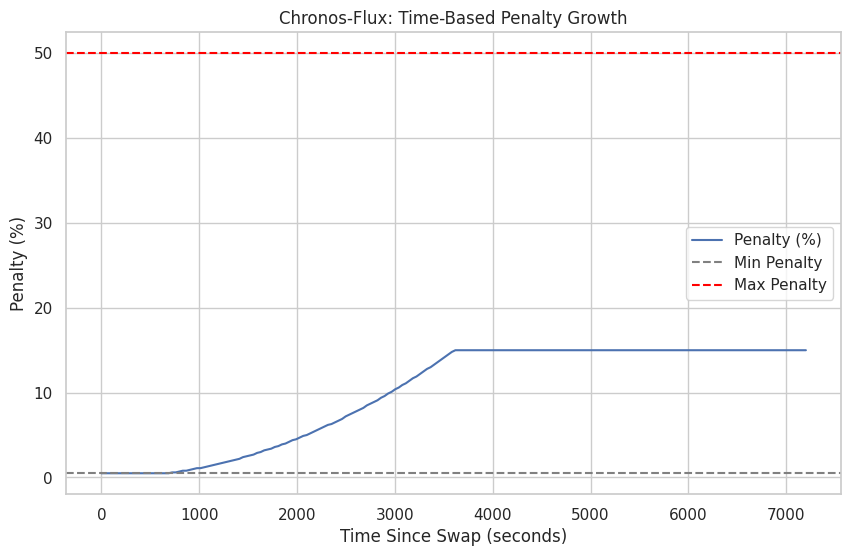

In [12]:
time_range = np.linspace(0, 2*T_MAX, 200)
penalty_curve = [compute_penalty(t, initial_deposit) for t in time_range]

plt.figure(figsize=(10,6))
plt.plot(time_range, np.array(penalty_curve)/SCALE*100, label='Penalty (%)')
plt.axhline(MIN_PENALTY/SCALE*100, color='gray', linestyle='--', label='Min Penalty')
plt.axhline(MAX_PENALTY/SCALE*100, color='red', linestyle='--', label='Max Penalty')
plt.xlabel('Time Since Swap (seconds)')
plt.ylabel('Penalty (%)')
plt.title('Chronos-Flux: Time-Based Penalty Growth')
plt.legend()
plt.show()

## Penalty Sensitivity: Varying Deposit and Volatility

Visualize how penalty changes with different initial deposits and volatility (sigma).

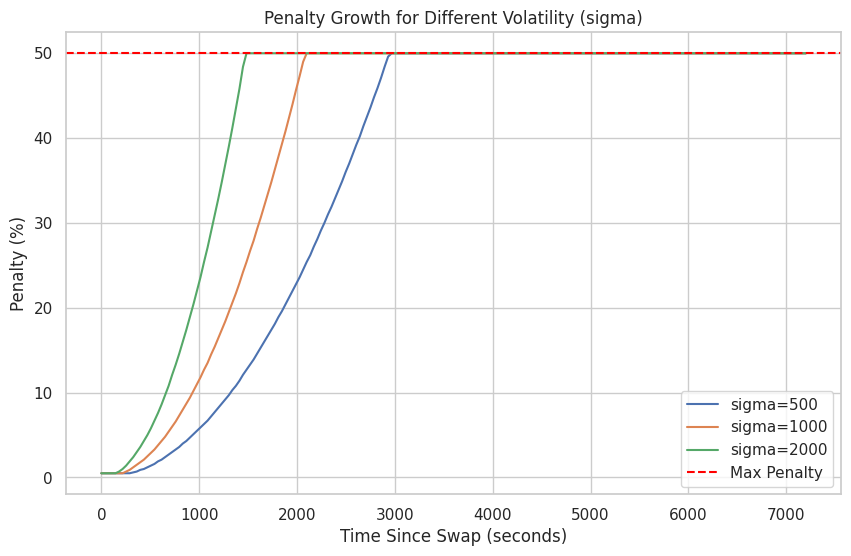

In [13]:
sigmas = [500, 1000, 2000]
plt.figure(figsize=(10,6))
for s in sigmas:
    dep = compute_initial_deposit(swap_size_usd, s)
    penalty_curve = [compute_penalty(t, dep) for t in time_range]
    plt.plot(time_range, np.array(penalty_curve)/SCALE*100, label=f'sigma={s}')
plt.axhline(MAX_PENALTY/SCALE*100, color='red', linestyle='--', label='Max Penalty')
plt.xlabel('Time Since Swap (seconds)')
plt.ylabel('Penalty (%)')
plt.title('Penalty Growth for Different Volatility (sigma)')
plt.legend()
plt.show()

## Edge Cases & Boundary Tests

Test minimum and maximum penalty, zero deposit, and excessive time.

In [14]:
# Zero deposit
print('Zero deposit penalty:', compute_penalty(1000, 0))
# Zero time
print('Zero time penalty:', compute_penalty(0, initial_deposit))
# Excessive time
print('Excessive time penalty:', compute_penalty(T_MAX*10, initial_deposit))
# Penalty at T_MAX
print('Penalty at T_MAX:', compute_penalty(T_MAX, initial_deposit))
# Penalty at half T_MAX
print('Penalty at T_MAX/2:', compute_penalty(T_MAX//2, initial_deposit))

Zero deposit penalty: 5
Zero time penalty: 5
Excessive time penalty: 150
Penalty at T_MAX: 150
Penalty at T_MAX/2: 37


## Fuzz/Randomized Test: Penalty Bounds

Test that penalty is always within [MIN_PENALTY, MAX_PENALTY] for random times and deposits.

In [15]:
np.random.seed(42)
num_tests = 2000
deposits = np.random.randint(0, 1_000_000, num_tests)
times = np.random.randint(0, T_MAX*5, num_tests)
violations = 0
for d, t in zip(deposits, times):
    p = compute_penalty(t, d)
    if not (MIN_PENALTY <= p <= MAX_PENALTY):
        violations += 1
print(f"Penalty bound violations: {violations} out of {num_tests}")
assert violations == 0

Penalty bound violations: 0 out of 2000


## Economic Intuition and Scenario Simulation

- The quadratic penalty incentivizes fast settlement: penalty grows slowly at first, then rapidly as time increases.
- Penalty is proportional to initial deposit, which is based on trade size and volatility.
- The system is robust to edge cases: penalty is always within bounds, and zero deposit/time is handled safely.

### Scenario: Delayed Settlement and Penalty Accumulation

Simulate a swap with delayed settlement and plot penalty accumulation over time.

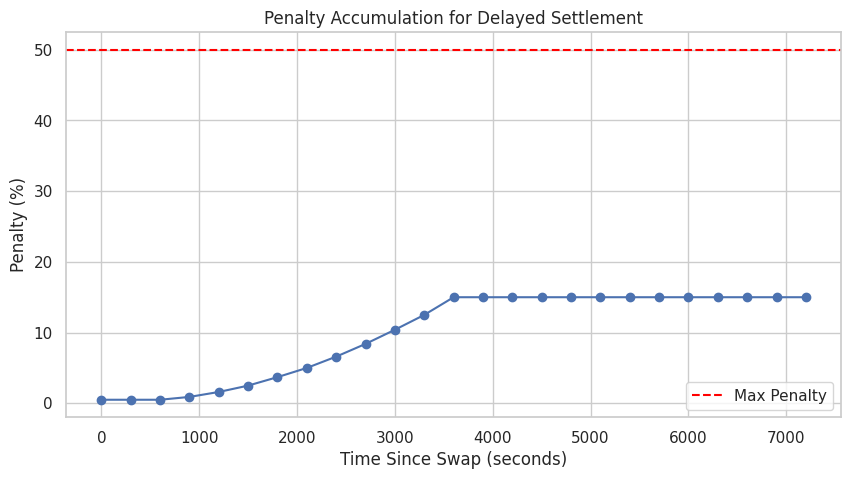

In [16]:
delayed_times = np.arange(0, 2*T_MAX+1, 300)
penalties = [compute_penalty(t, initial_deposit) for t in delayed_times]
plt.figure(figsize=(10,5))
plt.plot(delayed_times, np.array(penalties)/SCALE*100, marker='o')
plt.axhline(MAX_PENALTY/SCALE*100, color='red', linestyle='--', label='Max Penalty')
plt.xlabel('Time Since Swap (seconds)')
plt.ylabel('Penalty (%)')
plt.title('Penalty Accumulation for Delayed Settlement')
plt.legend()
plt.show()